# Loading Libraries

In [1]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, FunctionTransformer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer



import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions We Use

In this section, we will put the functions that we are going to use in the next sections. The first function is defined to be used in the pipelines and it returns the exact data it takes. The second and third functions do some basic cleaning and the last function print the result of the models' prediction.

In [2]:
def itself(data):
    return data

In [3]:
def new_cleaning(data):
    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")
    return cleaned_data

In [4]:
def text_from_token(data):    
    cleaned_sentence = " ".join(data)
    return  cleaned_sentence

In [15]:
def print_results(model, X_train, y_train,X_test, y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

# Importing Data

In [6]:
data = pd.read_csv("../EDA/cleaned_all/cleaned_all.csv")

data = data.sample(frac=1)

data.drop("Unnamed: 0", axis = 1, inplace = True)

data["cleaned"] =  data["cleaned"].apply(lambda x: new_cleaning(x))

data["for_glove"] =  data["for_glove"].apply(lambda x: new_cleaning(x))

data["cleaned_text"] = data["cleaned"].apply(lambda x: text_from_token(x))

# Train Test Split


In this section, we will split the dataframe into train and test sets and we will save these data sets to be used with other models in other notebooks.

In [7]:
X = data.drop("label", axis = 1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)


train.to_csv("../Modeling/train_test/train.csv")
test.to_csv("../Modeling/train_test/test.csv")



# Pipelines and Modeling

In this section, we will train different machine learning models on train set so that we could use them to filter out the fake news. The models we use are logistic regression, decision tree, random forest, xgboost and lightgbm. We will calculate TF-IDF for each token and for 2-grams. First we calculate the TF-IDF for each token and will train the models on these data sets. We will define different pipelines within which we have the model and tokenizers to calculate TF-IDF for each token and 2-grams.

## TF-IDF for 1-grams

In this section we make several pipelines within which we calculate the TF-IDF for 1-grams and then will feed them into the models.

### Making Pipelines

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [27]:
# Column Transformation

col_transformer = ColumnTransformer(
transformers=[
("tfidf", TfidfVectorizer(max_features=20000),"cleaned_text"),
("itself", FunctionTransformer(itself), ['neg', 'neu', 'pos', 
                                         'compound', 'num_urls'])
             ],    remainder="drop")



# Logistic Regression

lr = Pipeline([
("col transformer", col_transformer),
("Logistic Regression", LogisticRegression(class_weight="balanced",
                                           solver='liblinear',random_state=42))
              ])

# Decision Tree

tree = Pipeline([
("col transformer", col_transformer),
("Decision Tree",DecisionTreeClassifier(class_weight="balanced",criterion ="gini",
                                  max_depth = 20, random_state = 42))    
                ])

# Random Forest

forest = Pipeline([
("col transformer", col_transformer),   
("Random Forest",RandomForestClassifier(criterion="entropy", n_estimators=20,
                            bootstrap = True, random_state = 42))   
    
                 ])

# XGBoost

xgboost = Pipeline([
("col transformer", col_transformer),    
("xgb", xgb.XGBClassifier(max_depth=20,n_estimators=20,seed=42,
                  objective='binary:logistic', eval_metric = 'logloss'))
                  ])


# LightGBM
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'max_depth':20,
#         'eval_metric':"cross_entropy",
        'verbose':0,
        'random_seed': 42,
        'class_weight' :  'balanced',
        'force_row_wise' : True
          }

light = Pipeline([
("col transformer", col_transformer),
("lgbm", lgb.LGBMClassifier(**params))
])

### Logistic Regression

The first model we use is logistic regression and we can see that the accuracy for test sets is about 90% and the accuracy for the train set is about 92%. We may conclude that this model is not overfitted. 

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.87      0.92      0.90       0.89          0.90
      recall         0.87      0.91      0.90       0.89          0.90
      f1-score       0.87      0.91      0.90       0.89          0.90
      support     8719.00  13194.00      0.90   21913.00      21913.00
TRAIN precision      0.89      0.94      0.92       0.92          0.92
      recall         0.92      0.93      0.92       0.92          0.92
      f1-score       0.90      0.94      0.92       0.92          0.92
      support    17502.00  26987.00      0.92   44489.00      44489.00

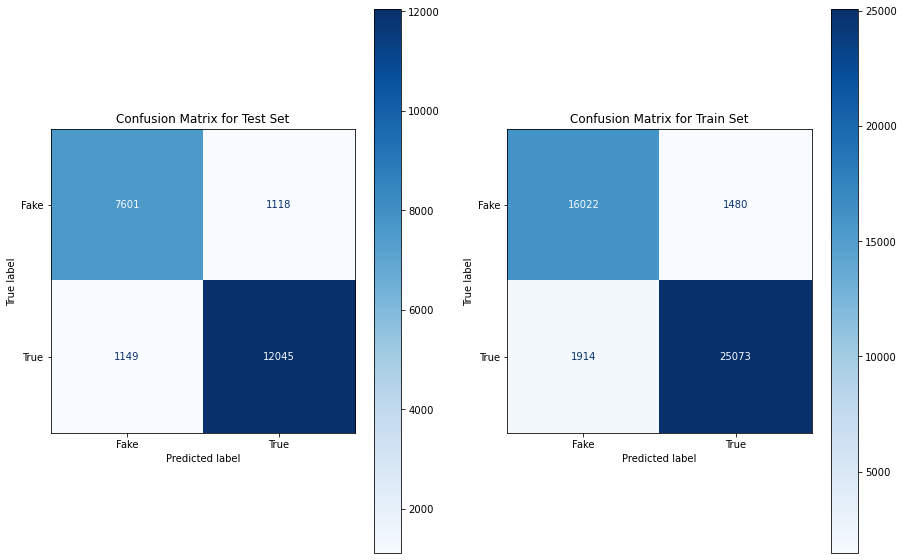

In [16]:
lr.fit(X_train, y_train)
print_results(lr, X_train, y_train, X_test, y_test)

### Decision Tree

The second model we consider is decision tree. We can see that the test accuracy is about 89% and the accuracy for the train set is 94%. We can see that this model did not perform better than the previous model.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.88      0.89      0.89       0.89          0.89
      recall         0.82      0.93      0.89       0.88          0.89
      f1-score       0.85      0.91      0.89       0.88          0.89
      support     8719.00  13194.00      0.89   21913.00      21913.00
TRAIN precision      0.95      0.93      0.94       0.94          0.94
      recall         0.89      0.97      0.94       0.93          0.94
      f1-score       0.92      0.95      0.94       0.93          0.94
      support    17502.00  26987.00      0.94   44489.00      44489.00

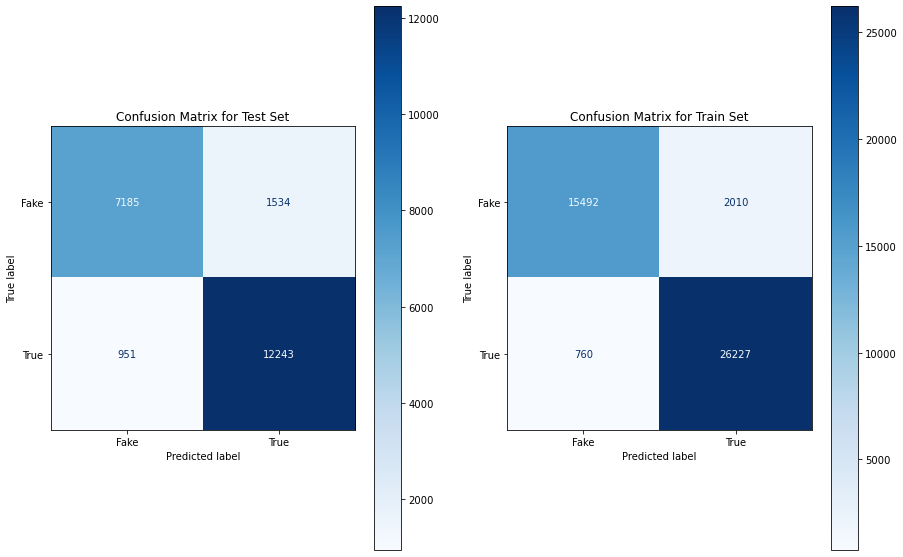

In [17]:
tree.fit(X_train, y_train)
print_results(tree, X_train, y_train, X_test, y_test)

### Random Forest

Random forest is the third model that we use to train. We can see that the accuracy of this model when it predicts the test set is about 88% while its accuracy for the training set is about 100%. We can see that this model is suffering from overfitting. To solve this issue we may perform grid search over different parameters. However, we will not do it in this notebook.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.88      0.90      0.89       0.89          0.89
      recall         0.84      0.92      0.89       0.88          0.89
      f1-score       0.86      0.91      0.89       0.88          0.89
      support     8719.00  13194.00      0.89   21913.00      21913.00
TRAIN precision      1.00      1.00      1.00       1.00          1.00
      recall         1.00      1.00      1.00       1.00          1.00
      f1-score       1.00      1.00      1.00       1.00          1.00
      support    17502.00  26987.00      1.00   44489.00      44489.00

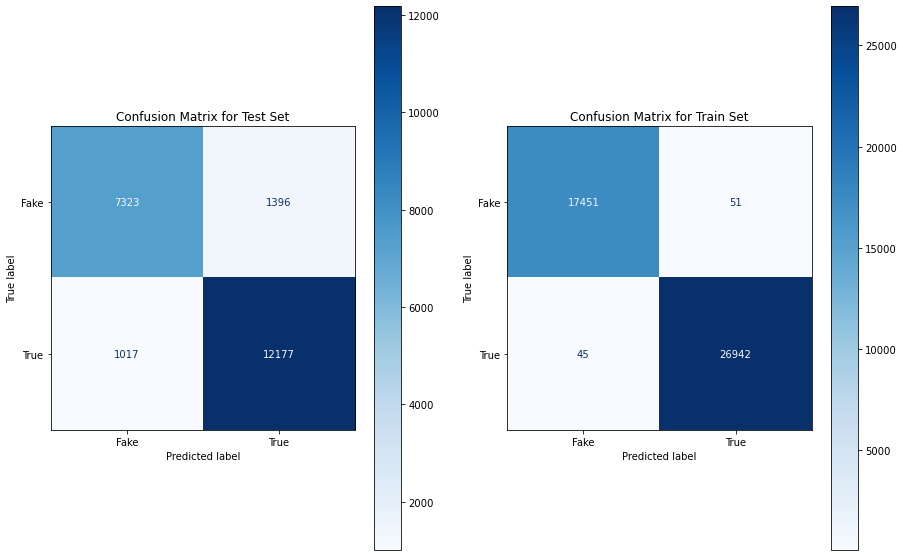

In [18]:
forest.fit(X_train, y_train)
print_results(forest, X_train, y_train, X_test, y_test)

### XGBoost

Now, we will use xgboost to train on the training set and we will check its performance by checking its prediction over the test sets. We can see that the accuracy for the test sets is about 91% and for the training set is about 96%. So, it seems that this model perform better than the other models and it is not overfitted.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.91      0.90      0.91       0.91          0.91
      recall         0.84      0.95      0.91       0.90          0.91
      f1-score       0.88      0.92      0.91       0.90          0.90
      support     8719.00  13194.00      0.91   21913.00      21913.00
TRAIN precision      0.99      0.94      0.96       0.96          0.96
      recall         0.90      0.99      0.96       0.95          0.96
      f1-score       0.94      0.97      0.96       0.95          0.96
      support    17502.00  26987.00      0.96   44489.00      44489.00

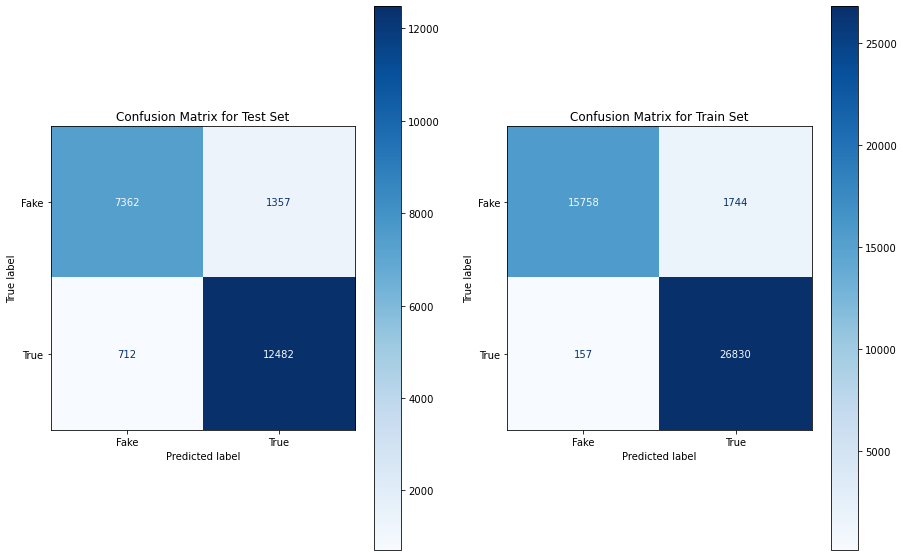

In [19]:
xgboost.fit(X_train, y_train)
print_results(xgboost, X_train, y_train, X_test, y_test)

### LightGBM

The last model we use in this section is LightGBM. We will train this model on training sets and will evaluate its performance by checking its prediction on test sets. We can see that the accuracy of this model for the test set is about 89% and the accuracy of this model for the training set is about 90%. This shows that this model is not overfitted at all. On the other hand, even though its test accuracy is smaller that the one obtained by xgboost, but we can see that the recall score for the "Fake News" is better than xgboost. 

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.87      0.91      0.89       0.89          0.89
      recall         0.86      0.91      0.89       0.89          0.89
      f1-score       0.86      0.91      0.89       0.89          0.89
      support     8719.00  13194.00      0.89   21913.00      21913.00
TRAIN precision      0.87      0.91      0.90       0.89          0.90
      recall         0.86      0.92      0.90       0.89          0.90
      f1-score       0.87      0.91      0.90       0.89          0.90
      support    17502.00  26987.00      0.90   44489.00      44489.00

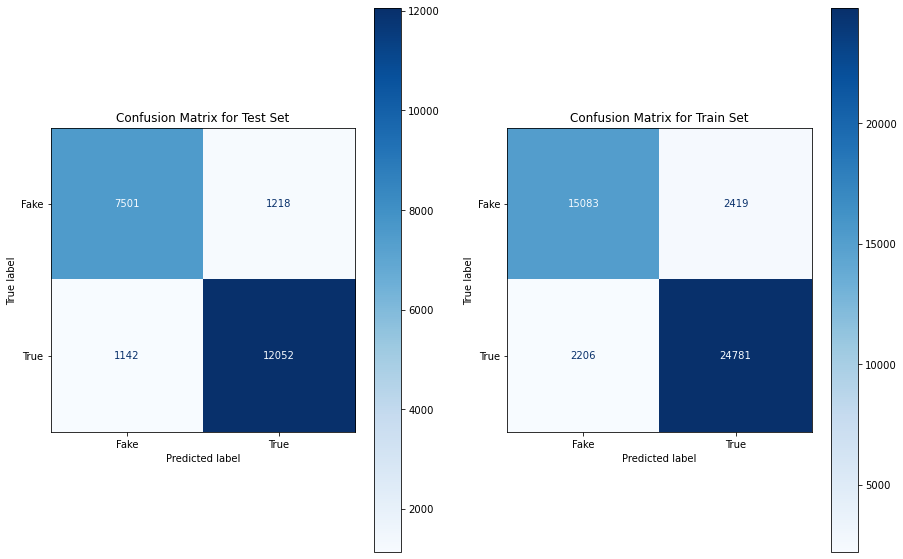

In [28]:
light.fit(X_train, y_train)
print_results(light, X_train, y_train, X_test, y_test)

## TF-IDF for 2-grams

In this section, we will define several pipelines with which we calcualte the TF-IDF for 2-grams and then will feed them into the model to train.

### Making Pipelines

In [30]:
# Column Transformation

col_transformer_ngram = ColumnTransformer(
transformers=[
("tfidf", TfidfVectorizer(max_features= 10000, ngram_range = (2,2)),"cleaned_text"),
("itself", FunctionTransformer(itself), ['neg', 'neu', 'pos', 'compound', 
                                         'num_urls'])
             ],    remainder="drop")


# LogisticRegression

lr_ngram = Pipeline([
("col transformer ngram", col_transformer_ngram),
("Logistic Regression ngram", LogisticRegression(class_weight="balanced",
                                                 solver='liblinear',
                                                 random_state=42))
              ])

# Decision Tree

tree_ngram = Pipeline([
("col transformer ngram", col_transformer_ngram),
("Decision Tree ngram",DecisionTreeClassifier(class_weight="balanced",criterion ="gini",
                                  max_depth = 20, random_state = 42))    
                ])

# Random Forest

forest_ngram = Pipeline([
("col transformer ngram", col_transformer_ngram),   
("Random Forest ngram",RandomForestClassifier(criterion="entropy", n_estimators=20,
                            bootstrap = True, random_state = 42))   
    
                 ])

# XGBoost

xgboost_ngram = Pipeline([
("col transformer ngram", col_transformer_ngram),    
("xgb ngram", xgb.XGBClassifier(max_depth=20,n_estimators=20,seed=42,
                  objective='binary:logistic', eval_metric = 'logloss'))
                  ])


# LightGBM
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'max_depth':20,
#         'eval_metric':"cross_entropy",
        'verbose':0,
        'random_seed': 42,
        'class_weight' :  'balanced',
        'force_row_wise' : True
          }

light_ngram = Pipeline([
("col transformer ngram", col_transformer_ngram),
("lgbm ngram", lgb.LGBMClassifier(**params))
])

### Logistic Regression

The first model is logistic regression. As we can see the accuracy of this model in predicting the test sets is about 88% and on the training set is 90%. Compared to the case where it was fed with TF-IDF of 1-grams, the performance did not improve and we can say that these two models might perform the same. However the recall score for this model is smaller than the the previous model.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.87      0.88      0.88       0.87          0.88
      recall         0.81      0.92      0.88       0.87          0.88
      f1-score       0.84      0.90      0.88       0.87          0.88
      support     8719.00  13194.00      0.88   21913.00      21913.00
TRAIN precision      0.89      0.91      0.90       0.90          0.90
      recall         0.86      0.93      0.90       0.89          0.90
      f1-score       0.87      0.92      0.90       0.90          0.90
      support    17502.00  26987.00      0.90   44489.00      44489.00

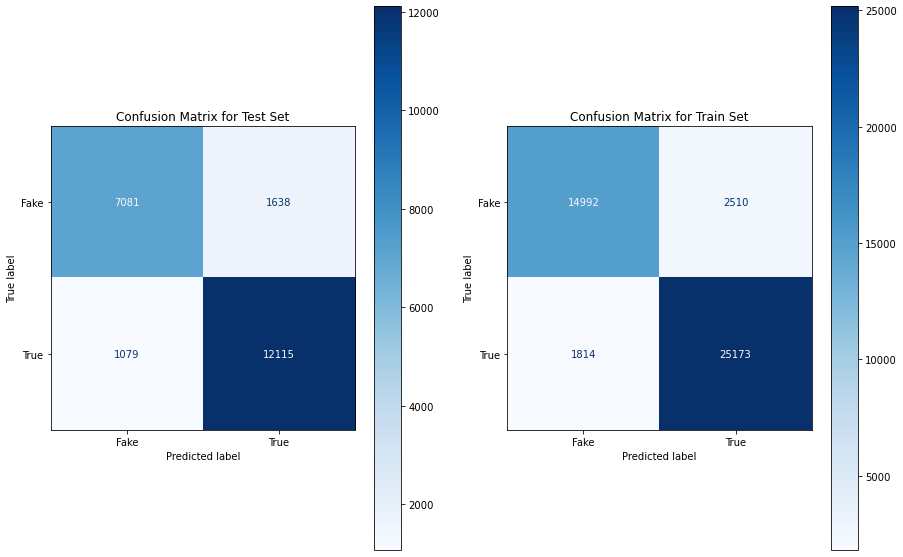

In [22]:
lr_ngram.fit(X_train, y_train)
print_results(lr_ngram, X_train, y_train, X_test, y_test)

### Decision Tree

The second model is decision tree. After being trained on the training set, we can see that the accuracy scores that has for both training and test sets is smaller that compared to the case where it was trained on the TF-IDF of the 1-grams. Therefore, the performance of this model is not improved.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.74      0.85      0.81       0.80          0.81
      recall         0.79      0.82      0.81       0.80          0.81
      f1-score       0.76      0.83      0.81       0.80          0.81
      support     8719.00  13194.00      0.81   21913.00      21913.00
TRAIN precision      0.77      0.88      0.84       0.83          0.84
      recall         0.83      0.84      0.84       0.84          0.84
      f1-score       0.80      0.86      0.84       0.83          0.84
      support    17502.00  26987.00      0.84   44489.00      44489.00

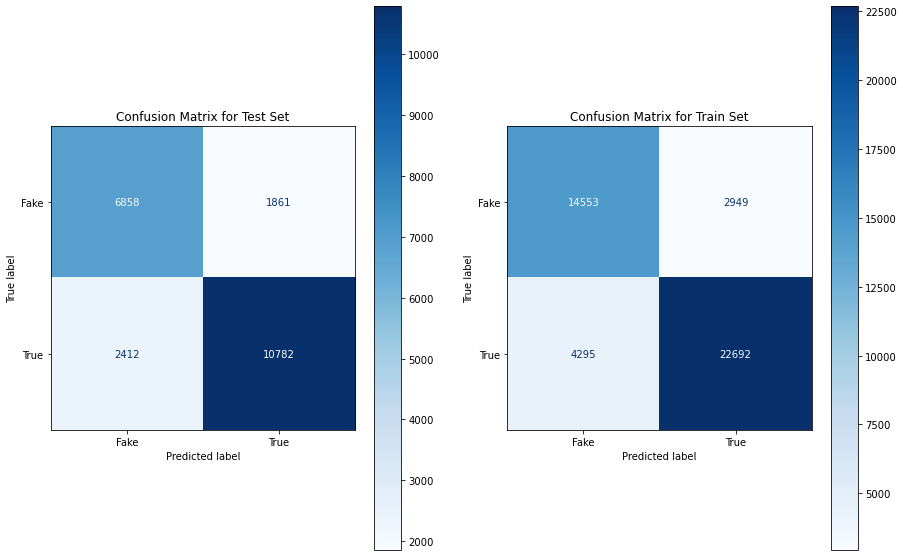

In [23]:
tree_ngram.fit(X_train, y_train)
print_results(tree_ngram, X_train, y_train, X_test, y_test)

### Random Forest

The third model we train is random forest. We noticed that when we trained it on the TF-IDF of 1-grams, this model showed signs of overfitting. However, in this case, we still see signs of overfitting.

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.86      0.88      0.88       0.87          0.88
      recall         0.82      0.92      0.88       0.87          0.88
      f1-score       0.84      0.90      0.88       0.87          0.88
      support     8719.00  13194.00      0.88   21913.00      21913.00
TRAIN precision      0.99      0.97      0.97       0.98          0.97
      recall         0.95      0.99      0.97       0.97          0.97
      f1-score       0.97      0.98      0.97       0.97          0.97
      support    17502.00  26987.00      0.97   44489.00      44489.00

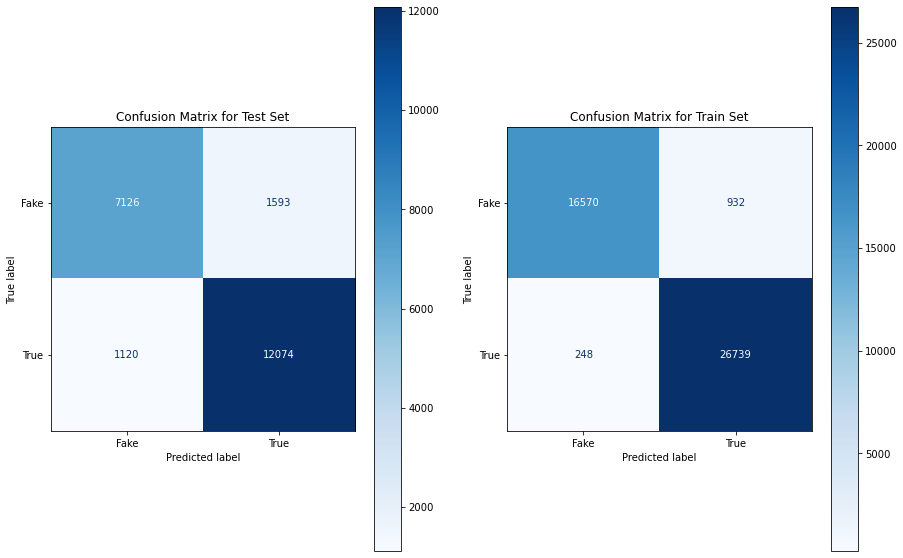

In [24]:
forest_ngram.fit(X_train, y_train)
print_results(forest_ngram, X_train, y_train, X_test, y_test)

### XGBoost

The forth model is xgboost, and we see that this model may not be overfitted. However, this model performs better when it is trained on 1-gram TF-IDF. 

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.90      0.86      0.87       0.88          0.88
      recall         0.77      0.94      0.87       0.85          0.87
      f1-score       0.83      0.90      0.87       0.86          0.87
      support     8719.00  13194.00      0.87   21913.00      21913.00
TRAIN precision      0.95      0.89      0.91       0.92          0.91
      recall         0.82      0.97      0.91       0.89          0.91
      f1-score       0.88      0.93      0.91       0.90          0.91
      support    17502.00  26987.00      0.91   44489.00      44489.00

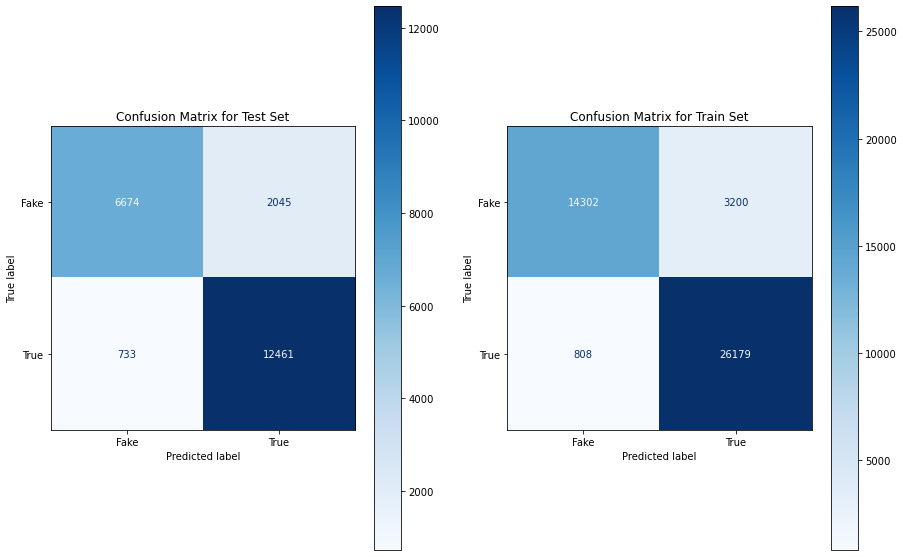

In [25]:
xgboost_ngram.fit(X_train, y_train)
print_results(xgboost_ngram, X_train, y_train, X_test, y_test)

### LightGBM

The last model of this notebook is LightGBM. We can see that this model is not overfitted but when it is trained on 1-gram TF-IDF it gives better results. 

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.85      0.85      0.85       0.85          0.85
      recall         0.76      0.91      0.85       0.84          0.85
      f1-score       0.80      0.88      0.85       0.84          0.85
      support     8719.00  13194.00      0.85   21913.00      21913.00
TRAIN precision      0.85      0.86      0.85       0.85          0.85
      recall         0.77      0.91      0.85       0.84          0.85
      f1-score       0.81      0.88      0.85       0.84          0.85
      support    17502.00  26987.00      0.85   44489.00      44489.00

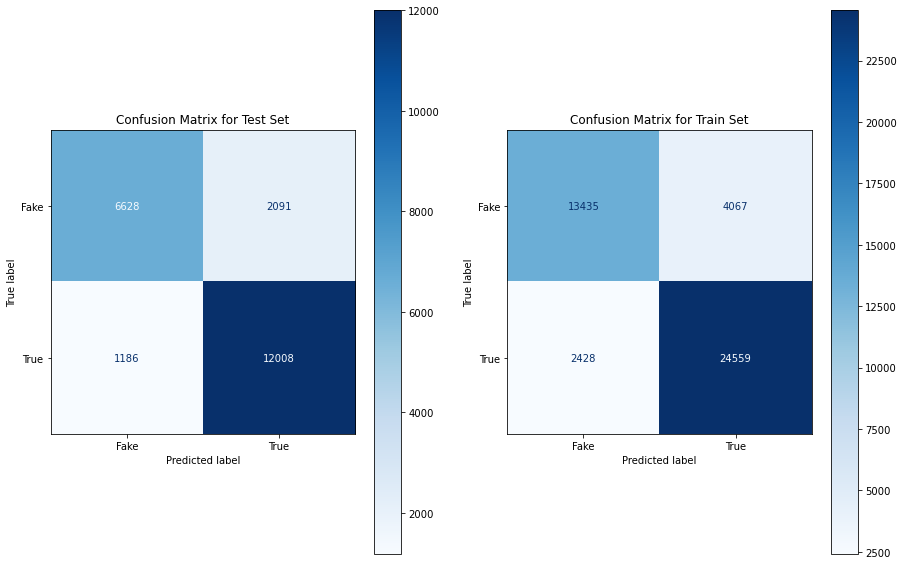

In [31]:
light_ngram.fit(X_train, y_train)
print_results(light_ngram, X_train, y_train, X_test, y_test)

# Summary of Models

We realized that when different model are trained on 1-gram TF-IDF, they perform better compared to when they are trained on 2-grams TF-IDF. By comparing the different accuracy results, we see that LightGBM is not showing any signs of overfitting. Also, the recall scores obtained from using logistic regression model and LightGBM are almost the same. Therefore, we would recommend either logistic regression or LightGBM as the final models of this notebook. 

In order to improve the performances of these models we may use grid search to optimize their hyper-parameters. Moreover, if we try to extract and engineer more information from the texts, we may be able to improve these models.